# Packages
Import the necessary libraries for data processing and analysis.

In [98]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

In [54]:
pd.set_option('display.max_columns', None)

# Loading Data
Load the processed football dataset for analysis.

In [55]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

df_logisitic = pd.read_pickle(PROCESSED_DIR / 'football_model_processed.pickle')

In [56]:
df_logisitic

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,shot_outcome_encoded,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,0,108.1,31.2,14.800338,12.831602,17.477128,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,1,110.9,42.6,9.464143,11.241441,9.207063,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,0,117.9,29.1,11.100450,7.212489,15.047259,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,1,101.8,27.6,22.022716,20.044949,24.498980,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,0,103.0,51.3,20.412986,22.871161,18.501081,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,0,103.8,51.4,19.809089,22.351734,17.810109,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


# Looking at Data
Examine the structure and contents of the loaded dataset.

In [57]:
X =df_logisitic.drop(columns = {'shot_outcome_encoded'})

In [58]:
X

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,body_part_head,body_part_other,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_other,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,108.1,31.2,14.800338,12.831602,17.477128,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,110.9,42.6,9.464143,11.241441,9.207063,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,117.9,29.1,11.100450,7.212489,15.047259,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,101.8,27.6,22.022716,20.044949,24.498980,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,103.0,51.3,20.412986,22.871161,18.501081,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,103.8,51.4,19.809089,22.351734,17.810109,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


In [59]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                 for i in tqdm(range(X.shape[1]))]

 24%|██▍       | 9/37 [00:00<00:01, 14.23it/s]/Users/kaspar/Library/Python/3.12/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 37/37 [00:02<00:00, 14.08it/s]


# Preparing Data for Training
Perform feature engineering and calculate the Variance Inflation Factor (VIF).

In [60]:
vif_df.sort_values('VIF')

,feature,VIF
0,under_pressure,1.126323e+00
3,shot_one_on_one,1.169597e+00
1,shot_open_goal,1.545723e+00
2,shot_first_time,1.593799e+00
31,goalkeeper_y,7.035979e+00
5,player_y,7.089747e+00
30,goalkeeper_x,1.195875e+01
34,gk_distance_from_goal_right_post,1.724929e+01
4,player_x,1.928334e+01
33,gk_distance_from_goal_left_post,1.991624e+01


In [61]:
cols = X.columns.tolist()

# Calculate correlation matrix
correlation_matrix = X[cols].corr()

# Find highly correlated pairs (>0.8 or <-0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'var1': correlation_matrix.columns[i],
                'var2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)

In [62]:
high_corr_df

,var1,var2,correlation
0,player_x,distance_from_goal_center,-0.940117
1,player_x,distance_from_goal_left_post,-0.920958
2,player_x,distance_from_goal_right_post,-0.918490
3,player_x,distance_player_gk,-0.923692
4,distance_from_goal_center,distance_from_goal_left_post,0.973185
5,distance_from_goal_center,distance_from_goal_right_post,0.973348
6,distance_from_goal_center,distance_player_gk,0.962259
7,distance_from_goal_left_post,distance_from_goal_right_post,0.895518
8,distance_from_goal_left_post,distance_player_gk,0.936404
9,distance_from_goal_right_post,distance_player_gk,0.940064


In [63]:
df_logisitic[['body_part_head','body_part_other','body_part_foot']].value_counts()
#can have any of them as baseline -> drop one

body_part_head  body_part_other  body_part_foot
0               0                1                 37554
1               0                0                  7519
0               1                0                   112
Name: count, dtype: int64

In [64]:
cols = [
    'shot_technique_backheel',
       'shot_technique_diving_header', 'shot_technique_half_volley',
       'shot_technique_lob', 'shot_technique_normal',
       'shot_technique_overhead_kick', 'shot_technique_volley'
]

# sum rows → if > 1 then perfect overlap
df_logisitic[cols].sum(axis=1).max()

np.where(df_logisitic[cols].sum(axis=1) == 0)[0]
#no times when nothing was filled

array([], dtype=int64)

In [65]:
#can drop one of the variables for baseline (e.g lob)

In [66]:
cols = [
    'play_pattern_from_corner', 'play_pattern_from_counter',
       'play_pattern_from_free_kick', 'play_pattern_from_goal_kick',
       'play_pattern_from_keeper', 'play_pattern_from_kick_off',
       'play_pattern_from_throw_in', 'play_pattern_other',
       'play_pattern_regular_play'
]

# sum rows → if > 1 then perfect overlap
df_logisitic[cols].sum(axis=1).max()

np.where(df_logisitic[cols].sum(axis=1) == 0)[0]

array([], dtype=int64)

In [67]:
df_logisitic[cols].sum(axis=0)
#can again drop one of these ones e.g play_pattern_other

play_pattern_from_corner        7374
play_pattern_from_counter       2039
play_pattern_from_free_kick     9640
play_pattern_from_goal_kick     1726
play_pattern_from_keeper         776
play_pattern_from_kick_off       503
play_pattern_from_throw_in      8091
play_pattern_other                54
play_pattern_regular_play      14982
dtype: int64

In [68]:
df_logisitic[['shot_type_open_play','shot_type_free_kick']].sum(axis=0)
#can drop one e.g free kick

shot_type_open_play    43061
shot_type_free_kick     2124
dtype: int64

In [69]:
df_logisitic.columns

Index(['under_pressure', 'shot_open_goal', 'shot_first_time',
       'shot_one_on_one', 'shot_outcome_encoded', 'player_x', 'player_y',
       'distance_from_goal_center', 'distance_from_goal_left_post',
       'distance_from_goal_right_post', 'body_part_head', 'body_part_other',
       'body_part_foot', 'shot_technique_backheel',
       'shot_technique_diving_header', 'shot_technique_half_volley',
       'shot_technique_lob', 'shot_technique_normal',
       'shot_technique_overhead_kick', 'shot_technique_volley',
       'play_pattern_from_corner', 'play_pattern_from_counter',
       'play_pattern_from_free_kick', 'play_pattern_from_goal_kick',
       'play_pattern_from_keeper', 'play_pattern_from_kick_off',
       'play_pattern_from_throw_in', 'play_pattern_other',
       'play_pattern_regular_play', 'shot_type_free_kick',
       'shot_type_open_play', 'goalkeeper_x', 'goalkeeper_y',
       'gk_distance_from_goal_center', 'gk_distance_from_goal_left_post',
       'gk_distance_from_goa

In [70]:
X =df_logisitic.drop(columns = {'shot_outcome_encoded','body_part_other','shot_technique_lob','play_pattern_other','shot_type_free_kick', 'distance_from_goal_left_post','distance_from_goal_right_post','player_x','goalkeeper_x','gk_distance_from_goal_left_post',
       'gk_distance_from_goal_right_post'})

In [71]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                 for i in tqdm(range(X.shape[1]))]

100%|██████████| 27/27 [00:01<00:00, 17.43it/s]


In [72]:
vif_df.sort_values('VIF')

,feature,VIF
3,shot_one_on_one,1.216045
1,shot_open_goal,1.420881
9,shot_technique_diving_header,1.468659
8,shot_technique_backheel,1.497659
0,under_pressure,1.545239
12,shot_technique_overhead_kick,1.703103
2,shot_first_time,2.320539
19,play_pattern_from_kick_off,6.121028
18,play_pattern_from_keeper,8.839627
13,shot_technique_volley,9.368950


In [73]:
cols = X.columns.tolist()

# Calculate correlation matrix
correlation_matrix = X[cols].corr()

# Find highly correlated pairs (>0.8 or <-0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'var1': correlation_matrix.columns[i],
                'var2': correlation_matrix.columns[j],
                'correlation': correlation_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)

In [74]:
high_corr_df

,var1,var2,correlation
0,player_y,goalkeeper_y,0.716270
1,distance_from_goal_center,shot_angle,-0.757344
2,distance_from_goal_center,distance_player_gk,0.962259
3,body_part_head,body_part_foot,-0.991157
4,shot_technique_half_volley,shot_technique_normal,-0.744229


In [75]:
X =df_logisitic.drop(columns = {'shot_outcome_encoded','body_part_other','shot_technique_lob','play_pattern_other','shot_type_free_kick', 'distance_from_goal_left_post','distance_from_goal_right_post','player_x','goalkeeper_x','gk_distance_from_goal_left_post',
       'gk_distance_from_goal_right_post'})

In [76]:
y=df_logisitic['shot_outcome_encoded']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y  # Keep same class distribution
)

In [78]:
X_train.shape, X_test.shape

((33888, 27), (11297, 27))

In [79]:
X_train

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,player_y,distance_from_goal_center,body_part_head,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_regular_play,shot_type_open_play,goalkeeper_y,gk_distance_from_goal_center,shot_angle,distance_player_gk
24426,0,0,1,0,39.3,27.808812,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,40.6,1.431782,0.285633,26.531868
10869,0,0,0,0,13.9,30.458168,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,36.9,3.289377,0.136903,27.242614
9896,0,0,1,0,19.0,29.207704,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,38.0,2.973214,0.191625,26.241380
26743,0,0,0,0,68.7,45.107982,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,42.9,7.576939,0.137044,37.927299
41512,1,0,1,0,47.8,10.089599,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,44.0,4.308132,0.538016,6.122091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17643,0,0,1,0,31.8,19.688829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,38.6,3.584690,0.367778,16.105900
31515,0,0,0,0,23.4,24.266232,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,39.7,2.121320,0.242328,22.562136
12539,0,0,1,0,33.1,12.397580,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,37.6,3.920459,0.539244,8.490583
12537,0,0,0,0,31.6,28.945639,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,39.8,0.824621,0.263372,28.122055


In [80]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2                       # not binary
]

cont_cols

['player_y',
 'distance_from_goal_center',
 'goalkeeper_y',
 'gk_distance_from_goal_center',
 'shot_angle',
 'distance_player_gk']

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])


In [82]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Test different penalty strengths
}

lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',  # Required for L1
    max_iter=1000,
    random_state=123
)

# GridSearchCV performs 5-fold cross-validation on TRAINING data only
grid_search = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Optimize for AUC
    n_jobs=-1,  # Use all CPU cores
    verbose=3
)

print("\n" + "="*50)
print("Running 5-fold CV to find optimal C parameter...")
print("="*50)

# Fit on training data only
grid_search.fit(X_train_scaled, y_train)


Running 5-fold CV to find optimal C parameter...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 2/5] END ...........................C=0.001;, score=0.772 total time=   0.2s
[CV 1/5] END ...........................C=0.001;, score=0.749 total time=   0.2s
[CV 3/5] END ...........................C=0.001;, score=0.773 total time=   0.2s
[CV 4/5] END ...........................C=0.001;, score=0.779 total time=   0.3s
[CV 5/5] END ...........................C=0.001;, score=0.762 total time=   0.2s
[CV 1/5] END ............................C=0.01;, score=0.790 total time=   0.3s
[CV 5/5] END ............................C=0.01;, score=0.807 total time=   0.2s
[CV 2/5] END ............................C=0.01;, score=0.802 total time=   0.3s
[CV 4/5] END ............................C=0.01;, score=0.805 total time=   0.3s
[CV 3/5] END ............................C=0.01;, score=0.801 total time=   0.3s
[CV 2/5] END .............................C=0.1;, score=0.805 total time=   0.6s

,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [83]:
print("\n" + "="*50)
print("Cross-Validation Results:")
print("="*50)
print(f"\nBest C parameter: {grid_search.best_params_['C']}")
print(f"Best CV AUC score: {grid_search.best_score_:.4f}")


Cross-Validation Results:

Best C parameter: 1
Best CV AUC score: 0.8055


In [84]:
# Show all CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
print("\nAll CV results:")
print(cv_results[['param_C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

# 5. Get the best model (already fitted on full training set)
best_model = grid_search.best_estimator_


All CV results:
    param_C  mean_test_score  std_test_score
3     1.000         0.805479        0.003730
4    10.000         0.805417        0.003608
5   100.000         0.805410        0.003600
6  1000.000         0.805408        0.003596
2     0.100         0.804865        0.004609
1     0.010         0.800952        0.005968
0     0.001         0.766917        0.010396


In [85]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': best_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

In [86]:
feature_importance

,feature,coefficient
8,shot_technique_backheel,-1.444217
22,shot_type_open_play,-1.303452
12,shot_technique_overhead_kick,-1.183419
1,shot_open_goal,0.915626
5,distance_from_goal_center,-0.761605
7,body_part_foot,0.709849
10,shot_technique_half_volley,-0.691673
13,shot_technique_volley,-0.625975
9,shot_technique_diving_header,0.562081
25,shot_angle,0.500571


# Evaluate Model

In [87]:
# 7. Evaluate on TEST SET (the held-out 25%)
print("\n" + "="*50)
print("Test Set Performance:")
print("="*50)

# Predict probabilities
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

# Calculate AUC
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Set Performance:

Test AUC: 0.7953

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10216
           1       0.61      0.12      0.20      1081

    accuracy                           0.91     11297
   macro avg       0.76      0.56      0.58     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10135    81]
 [  952   129]]


In [88]:
y_test_pred_proba

array([0.06956772, 0.02452653, 0.01508592, ..., 0.03656654, 0.04062337,
       0.01158662], shape=(11297,))

In [89]:
y_test

6457     1
24146    0
11254    0
8245     0
44143    1
        ..
34990    0
9423     0
17105    0
29910    0
5853     0
Name: shot_outcome_encoded, Length: 11297, dtype: int64

In [90]:
X_test

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,player_y,distance_from_goal_center,body_part_head,body_part_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley,play_pattern_from_corner,play_pattern_from_counter,play_pattern_from_free_kick,play_pattern_from_goal_kick,play_pattern_from_keeper,play_pattern_from_kick_off,play_pattern_from_throw_in,play_pattern_regular_play,shot_type_open_play,goalkeeper_y,gk_distance_from_goal_center,shot_angle,distance_player_gk
6457,0,0,0,0,36.0,11.236103,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,39.7,0.761577,0.651077,10.475209
24146,0,0,0,0,23.3,23.266500,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,37.4,3.405877,0.241872,19.869826
11254,0,0,0,0,51.4,30.046630,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,40.8,2.247221,0.245721,27.800180
8245,0,0,0,0,35.5,19.915070,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,39.5,1.868154,0.387184,18.048823
44143,0,1,1,0,36.9,6.140033,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,42.6,3.676955,1.097759,6.307139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34990,0,0,0,0,58.4,28.071338,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,42.8,3.959798,0.216254,24.123018
9423,0,0,1,0,39.5,21.705760,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,40.4,1.264911,0.364388,20.519747
17105,0,0,0,0,22.6,25.179357,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,38.1,3.894868,0.231379,21.431052
29910,1,0,0,1,45.7,15.023315,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,42.0,4.382921,0.487578,10.662551


In [91]:
X_test_copy = X_test.copy()

In [92]:
X_test_copy['xG_lasso'] = y_test_pred_proba

In [93]:
pd.concat([X_test_copy['xG_lasso'],y_test],axis=1)

,xG_lasso,shot_outcome_encoded
6457,0.069568,1
24146,0.024527,0
11254,0.015086,0
8245,0.056891,0
44143,0.662787,1
...,...,...
34990,0.021201,0
9423,0.046454,0
17105,0.036567,0
29910,0.040623,0


In [95]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

NameError: name 'auc' is not defined

# Calibration curve 

In [104]:
import numpy as np
evaluation = pd.DataFrame(y_test_pred_proba, y_test).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

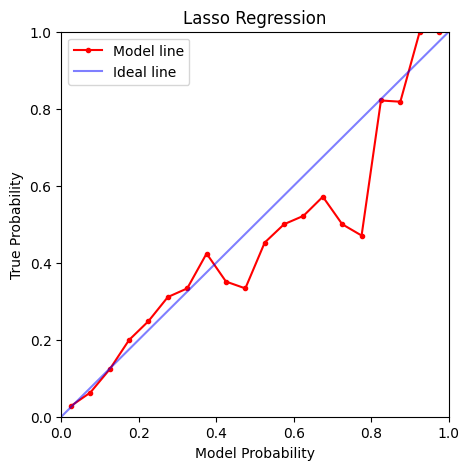

In [105]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.figure(figsize=(5, 5))

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axvspan(0.9, 1, alpha=0.1, label = "No shots with prob > 0.9", color = "red")
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.title("Lasso Regression")
plt.show()

In [99]:
from sklearn.metrics import brier_score_loss

# Compute Brier score for the test set predictions
brier_score = brier_score_loss(y_test, y_test_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

Brier Score: 0.0732


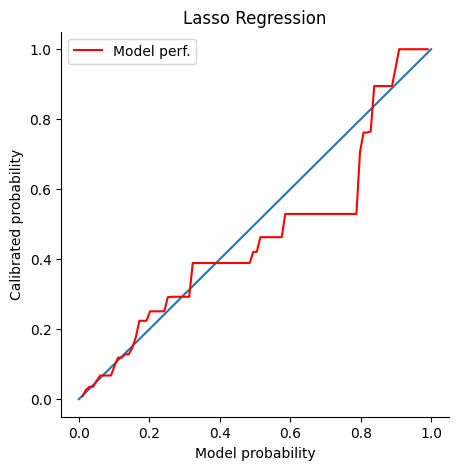

In [102]:
import sklearn.isotonic as sk_i
import seaborn as sns
i_r = sk_i.IsotonicRegression().fit(evaluation["pred_prob"], evaluation["outcome"])

model_probs = np.linspace(0, 1, num=100)

calibrated_probs = i_r.predict(model_probs)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])

plt.plot(model_probs, calibrated_probs, color='red', label = "Model perf.")

plt.legend()

plt.title("Lasso Regression")
plt.xlabel('Model probability')
plt.ylabel('Calibrated probability')

sns.despine()